# Text Classification on Amazon Reviews

This notebook plots the results of various optimization algorithms on the Amazon Reviews distribution shift benchmark.

In [83]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import pickle
import numpy as np
import pandas as pd

sys.path.append("..")
from src.utils.io import var_to_str, get_path, load_results
from src.utils.data import load_dataset

In [84]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 28
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [85]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

def plot_traj(
    ax,
    dataset,
    model_cfg,
    plot_cfg,
    seeds,
    out_path="../results/",
    verbose=False,
    n_points=16,
    markersize=8,
    n_epochs=None,
):
    filename = plot_cfg["optimizer"]  # "code" name (e.g. "lsvrg")
    label = plot_cfg["label"]  # display name
    color = plot_cfg["color"]
    linestyle = plot_cfg["linestyle"]

    X_train = load_dataset(dataset, data_path="../data/")[0]
    n = len(X_train)
    d = X_train.shape[1]

    path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
   
    df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
    opt = pickle.load(open(os.path.join(path, "best_cfg.p"), "rb"))
    if verbose:
        print(f"{filename} best config:", opt)
    avg_train_loss = torch.tensor(df["average_train_loss"])
    epoch_len = opt["epoch_len"]

    epochs = torch.arange(len(avg_train_loss))
    subopt = get_suboptimality(
        dataset, model_cfg, avg_train_loss, out_path=out_path
    )
    # rescale algorithms that make multiple gradient evaluations per iteration
    if filename == "lsvrg":
        if epoch_len:
            x = epochs * (epoch_len + n) / n
        else:
            x = epochs * 2
    elif filename == "moreau":
        if epoch_len:
            x = epochs * 2 * epoch_len / n
        else:
            x = epochs * 2
    else:
        if epoch_len:
            x = epochs * min(epoch_len * 64, n) / n
        else:
            x = epochs
    if n_epochs:
        idx = x < min(len(subopt), n_epochs)
    else:
        idx = x < len(subopt)
    downsample = torch.sum(idx).item() // n_points
    ax.plot(
        x[idx][::downsample],
        subopt[idx][::downsample],
        color=color,
        label=label,
        linestyle=linestyle,
        marker=plot_cfg["marker"],
        markersize=markersize,
    )

In [86]:
dataset = "amazon"
loss = "multinomial_cross_entropy"
n_class = 5
l2_reg = 1.0
shift_cost = 1.0

result_dir = "../results"


In [87]:
l2_reg = 1.0
shift_cost = 1.0

base = "/home/hp/pai/check1/prospect/experiments/results"
obj_names = ["CVaR", "ESRM"]

In [88]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
        "epsilon":2,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=2",
        "color": "yellow",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":2,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=4",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":4,
    },

    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD eps=8",
        "color": "blue",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":8,
    }
]

In [89]:
def get_mypath(base_dir,model_cfg,datset,specific_cfg):
    path1 = get_path([datset,var_to_str(model_cfg),var_to_str(specific_cfg)],base_dir)
    return path1

def get_mypath2(base_dir,model_cfg,datset):
    path1 = get_path([datset,var_to_str(model_cfg)],base_dir)
    return path1


In [90]:
def plot_ax(ax, seeds, objective, plot_cfg, dataset, epoch_len=None, n=4000, downsample=4, max_epoch=32, markersize=7, out_path="../results/"):
    optimizer = plot_cfg['optimizer']
    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": "multinomial_cross_entropy",
        "n_class": 5,
        "shift_cost": shift_cost
    }
    for seed in seeds:
        filename = plot_cfg["optimizer"]
        path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
        df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
        # print(df)
        best_cfg = pickle.load(open(os.path.join(path, "best_cfg.p"), "rb"))
        print(best_cfg)
        train_loss = torch.tensor(df["average_train_loss"])
        epochs = torch.arange(len(train_loss))
        subopt = get_suboptimality(
            dataset, model_cfg, train_loss, out_path=out_path
        )
        if optimizer == "lsvrg":
            x = epochs * 2
        elif optimizer in ["sgd", "srda"]:
            x = epochs
        else:
            x = epochs
        idx = (x <= max_epoch)
        ax.plot(
            x[idx][::downsample], 
            subopt[idx][::downsample], 
            label=plot_cfg['label'], 
            color=plot_cfg['color'],
            marker=plot_cfg['marker'],
            markersize=markersize
        )



# def get_iterates(objective, optimizer, seed=1, dataset="amazon"):
#     model_cfg = {
#         "objective": objective,
#         "l2_reg": l2_reg,
#         "loss": "multinomial_cross_entropy",
#         "n_class": 5,
#         "shift_cost": shift_cost
#     }

#     path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=result_dir)
#     f = os.path.join(path, f"iterates_{seed}.p")
#     return [iterate.view(-1, n_class).detach() for iterate in pickle.load(open(f, "rb"))]

def get_iterates(dataset,objective  ,optimizer, seed=1, result_dir=None):
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": "multinomial_cross_entropy",
        "n_class": 5,
        "shift_cost": shift_cost
    }
    best_path = get_mypath2(result_dir,model_cfg=model_cfg,datset=dataset)
    best_path = os.path.join(best_path,optimizer+"/best_cfg.p")
    specific_cfg = None
    with open(best_path, 'rb') as file:
        specific_cfg = pickle.load(file)
    print("objective",objective,"specific_cfg",specific_cfg)
    path = get_mypath(datset=dataset,model_cfg=model_cfg,base_dir=result_dir,specific_cfg=specific_cfg)
    f = os.path.join(path, f"seed_{seed}.p")
    data = pickle.load(open(f, "rb"))
    metrics_data = data['metrics']    
    weights = metrics_data['weights']
    return [iterate.view(-1, n_class) for iterate in weights]

In [91]:
X_train, y_train, X_test, y_test = load_dataset("amazon", data_path="../data/")
z_test = torch.tensor(np.load("../data/amazon/z_test.npy"))

print(X_test.shape)
print(y_test.shape)
print(z_test.shape)

torch.Size([10000, 107])
torch.Size([10000])
torch.Size([10000, 6])


In [92]:
metadata = pd.DataFrame(z_test).drop(columns=[0, 1, 5])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   2       10000 non-null  int64
 1   3       10000 non-null  int64
 2   4       10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [93]:
metadata.head()

,2,3,4
0,4,19,0
1,2,20,4
2,2,18,4
3,2,15,3
4,2,16,0


In [94]:
# def get_group_error(X_test,metadata,dataset,column, optimizer, objective,base_dir):
#     iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
#     df = metadata.copy()

#     for i, w in enumerate(iterates):
#         print(X_test.shape)
#         print(w.shape)
#         logits = X_test @ w
#         df[f"error_{i}"] = (y_test != torch.argmax(logits, dim=1)).int()

#     cols = [column] + [f"error_{i}" for i in range(len(iterates))]

#     # returns (T, G) numpy array where T is the number of iterates and G is the number of groups.
#     return df[cols].groupby([column]).mean().to_numpy().T

def get_group_error(X_test, metadata, dataset, column, optimizer, objective, base_dir):
    iterates = get_iterates(dataset=dataset, objective=objective, optimizer=optimizer, result_dir=base_dir)
    df = metadata.copy()
    error_columns = []  # List to accumulate error columns

    for i, w in enumerate(iterates):
        if i==0:
            
            print("w.shape",w.shape,"X_test.shape",X_test.shape)
        logits = X_test @ w
        error_tensor = (y_test != torch.argmax(logits, dim=1)).int()
        
        # Convert tensor to pandas Series and add to the list
        error_column = pd.Series(error_tensor.numpy(), name=f"error_{i}")
        error_columns.append(error_column)

    # Concatenate all error columns along with the original df
    error_df = pd.concat([df] + error_columns, axis=1)

    cols = [column] + [f"error_{i}" for i in range(len(iterates))]
    return error_df[cols].groupby([column]).mean().to_numpy().T



{'optimizer': 'sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 256, 'dataset_length': 10000, 'noise': 3.7105924117884594}
{'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 256, 'dataset_length': 10000, 'noise': 3.7105924117884594}
{'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 256, 'dataset_length': 10000, 'noise': 2.115852325269072}
{'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 256, 'dataset_length': 10000, 'noise': 1.3023631073857267}
{'optimizer': 'sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 256, 'dataset_length': 10000, 'noise': 3.7105924117884594}
{'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 256, 'dataset_length': 10000, 'noise': 3.7105924117884594}
{'optimizer': 'dp_sgd', 'lr': 0.3, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 256, 'dataset_length': 10000, 'noise': 2.1

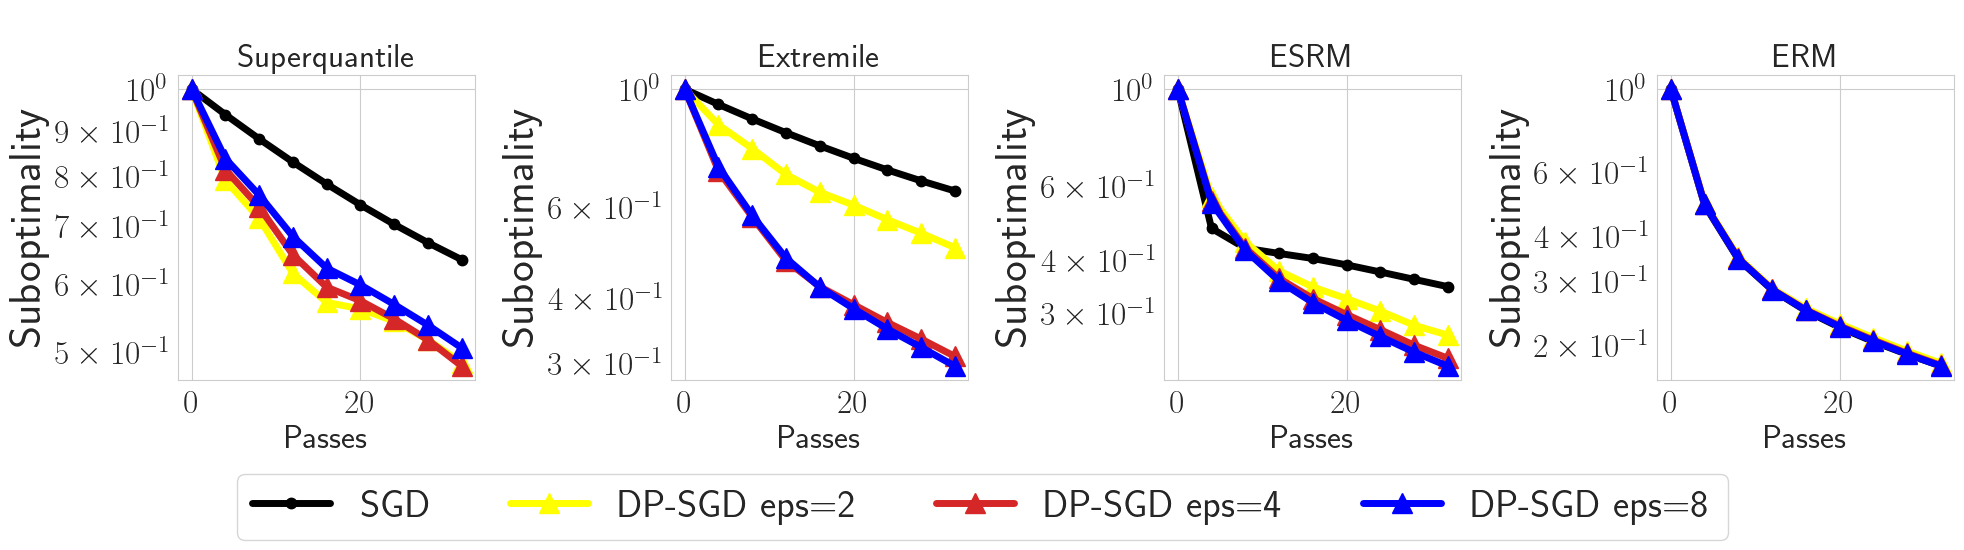

In [95]:
objectives = ["superquantile", "extremile","esrm","erm"]
column = 4
seeds = [1]

sns.set_style("whitegrid")

# fig, ax = plt.subplots(2, len(objectives), figsize=(5 * len(objectives), 10), sharey="row")
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

obj_names = ["Superquantile", "Extremile", "ESRM","ERM"]
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        optimizer = plot_cfg["optimizer"]
        epsilon = plot_cfg["epsilon"]  
        path = os.path.join(base + f"_{float(epsilon):.6f}")
        plot_ax(ax[j], seeds, objective, plot_cfg, dataset, markersize=15,out_path=path)
        ax[j].set_yscale("log")
        ax[ j].set_title( f"\n{obj_names[j]}", fontsize=24)
        # ax[j].set_xticklabels([])
        # ax[1, j].hlines(y=1.0, xmin=0, xmax=32, color="gray", linestyle="dashed")


for k in range(4):
    ax[k].set_xlabel(f"Passes", fontsize=24)

ax[0].set_ylabel(f"Suboptimality", fontsize=32)
ax[1].set_ylabel(f"Suboptimality", fontsize=32)
ax[2].set_ylabel(f"Suboptimality", fontsize=32)
ax[3].set_ylabel(f"Suboptimality", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.savefig(f"../figures/amazon_training_curves.pdf", bbox_inches="tight")
plt.show()